# Investigation on Fitting Methods for Different Separation of Lifetimes

In [3]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools
import statsmodels.api as sm
from scipy.optimize import minimize

plt.style.use('seaborn-v0_8-deep')

## Generate TCSPC Data for Fluorophore

In [4]:
def TCSPCsim(amplitudes, lifetimes, run_time, n_bins=380, window=20, bg=10, t0=10/19, deconv=False):
    '''Generate TCSPC fluorescence decay data (not Monte Carlo method).'''
    '''
    Inputs:
    - amplitudes: fractional intensities of each lifetime component (1d array)
    - lifetimes: lifetime array (1d array)
    - run_time: run time in seconds
    - irfwidth: sigma of Gaussian IRF
    - n_bins: number of histogram bins, default is 380
    - window: decay data time window in ns, default is 20
    - bg: background count rate, default is 10 counts per second
    - t0: IRF offset in ns, default is 10/19
    - deconv: if True, deconvolve the data with the IRF, default is False

    Outputs: 
    - t (time array)
    - noisydecay (decay data)
    '''
    t = np.linspace(0, window, n_bins)

    global irfwidth
        
    # Check that each amplitude has a corresponding lifetime
    if len(amplitudes) != len(lifetimes):
        return None, None
    
    # Generate the pure decay signal
    pure_decay = sum([amplitudes[j] * np.exp(-t / lifetimes[j]) for j in range(len(lifetimes))])
    
    # Generate the IRF
    irf_kernel = stats.norm.pdf(t, loc=t0, scale=irfwidth)
    
    # Convolve the pure decay with the IRF
    Iconvol = convolve(pure_decay, irf_kernel, mode='full')[:n_bins] / np.sum(irf_kernel)
    
    # Calculate the number of fluorescence counts
    fluorate = 2500 - bg  # Subtract background to get fluorescence rate
    totalfluorescence = fluorate * run_time
    noiseless = totalfluorescence * Iconvol / np.sum(Iconvol)
    noiseless += bg * run_time / n_bins  # Add background counts evenly
    
    # Add Poisson noise
    noisydecay = rng.poisson(noiseless)
    
    # Optionally deconvolve
    #if deconv:
        # Assuming deconv_fft function is defined elsewhere to handle deconvolution
    #    noisydecay = deconv_fft(noisydecay, kernel(t, t0, irfwidth))
    
    return t, noisydecay

def plot_TCSPC_decay(t, y, tau, logy=True, deconv=False, bins=None):
    '''Plot TCSPC decay.'''
    '''
    Inputs:
    - t: time array corresponding to the y data.
    - y: photon number array (ydata).
    - tau: lifetimes used in the simulation or data analysis.
    - logy: if True, y-axis will be on a logarithmic scale; linear otherwise.
    - deconv: if True, apply deconvolution to y using the instrument response function (IRF).
    - bins: the bins used for the histogram or decay curve; necessary if deconvolution is applied.
    '''
    fig, ax = plt.subplots() 

    ax.set_title(r'TCSPC Fluorescence Decay ($\tau =$' + ', '.join([f'{lifetime} ns' for lifetime in tau]) + ')')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Photon Count')
    
    if logy:
        ax.set_yscale('log')
    
    #if deconv and bins is not None:
        # Assuming deconv_fft and kernel functions are defined elsewhere.
        # You might need to adjust the parameters of kernel function based on your actual use case.
    #    y = deconv_fft(y, kernel(bins))
    
    # Check if y is a single dataset or contains multiple datasets
    if y.ndim == 1:
        # Single dataset
        ax.plot(t, y, label='Data')
    else:
        # Multiple datasets, e.g., from simulations with different lifetimes
        for i, y_i in enumerate(y):
            ax.plot(t, y_i, label=f'{tau[i]} ns')
    
    ax.legend()

    return

In [105]:
# Taking EGFP lifetimes of [3.07,2.43] as reference

tau1s = np.linspace(3.07,2.50,20) # Decrease separation
lifetimes = [[tau1s[i], 2.43] for i in range(len(tau1s))] # Create lifetimes array with τ2 fixed

#Set default params
irfwidth = 0.001

rng = np.random.default_rng()

In [106]:
# Generate TCSPC data
t_array = []
y_array = []

for lifetime in lifetimes:
    t = []
    y = []

    # Run 100 simulations for each pair of lifetimes
    for i in range(100):
        t_i,y_i = TCSPCsim([0.503,0.497],lifetime, 500*60)
        t.append(t_i)
        y.append(y_i)
    
    t_array.append(np.array(t))
    y_array.append(np.array(y))

t_array=np.array(t_array)
y_array=np.array(y_array)

## Perform Fitting

In [107]:
def exp2(t,A1,tau1,tau2):
    '''returns bi-exponential A1*exp(-t/tau1) + (1-A1)*exp(-t/tau2)
       t    time array (ns)
       A1   amplitude 1
       tau1 lifetime 1 (ns)
       tau2 lifetime 2 (ns)
    '''
    return A1*np.exp(-t/tau1)+(1-A1)*np.exp(-t/tau2)

def exp_fit(func,tdata,ydata,guess,run_time,end = int((15/20*380)),bg = 10,weights = None,method = 'powell'):
    '''use least-square fit for given exponential function (exp1 or exp2)
       Inputs:
       func      exp function to be fitted 
       tdata     time array (non-trimmed)
       ydata     photon count (non-trimmed)
       guess     guess intial parameters for fitting
       end       trim the end point to avoid low count statistics
       bg        background count per s
       run_time  run_time (s)
       weights   weights for the data points of the fit (1/yerr)
       method    fit method
       Outputs:
       result        lmfit result
       params_opt    fitted parameters
       chi2_red      reduced chi2
       fit_report    fit_report from lmfit
       '''
    model = Model(func)
    params = Parameters()
    # Get the parameter names and default values from the input function
    params_name = inspect.signature(func).parameters
    params_name = list(params_name.keys())[1:]  # Exclude 'x' from parameters
    for i,name in enumerate(params_name):
    # Add initial guess value for the parameter
        params.add(name,value=guess[i],min = 0)

    #Trim and scale data for fitting
    ydata = ydata-np.full(len(ydata),int(bg*run_time/len(tdata)))#subtract background from each bin
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    ydata = ydata/ydata[0] # scale y data such that the beginning is 1 

    
    result = model.fit(ydata, params, t=tdata,weights = weights,method = method) #perform least squares fit
    params_opt = result.params #optimized params
    chi2= result.chisqr #chi squared
    chi2_red = result.chisqr/(len(tdata)-len(params))
    fit_report = result.fit_report()
    return result, params_opt, chi2_red, fit_report

In [150]:
# Analyse for decreasing separation
run_time=500*60

guesses = [[0.503,tau1s[i], 2.43] for i in range(len(tau1s))] # Generate array for initial guesses

A1_array = []
tau1_array = []
tau2_array = []

for i in range(20): # Loop through the 20 pairs of lifetimes
    A1 = []
    tau1 = []
    tau2 = []

    for j in range(100): # Loop through 100 simulations
        result,params,chi2,report=exp_fit(exp2,t_array[i,j,:], y_array[i,j,:],guesses[i],run_time,method = 'powell')

        A1.append(params['A1'].value)
        tau1.append(params['tau1'].value)
        tau2.append(params['tau2'].value)
    
    A1_array.append(np.array(A1))
    tau1_array.append(np.array(tau1))
    tau2_array.append(np.array(tau2))

A1_array=np.array(A1_array)
tau1_array=np.array(tau1_array)
tau2_array=np.array(tau2_array)


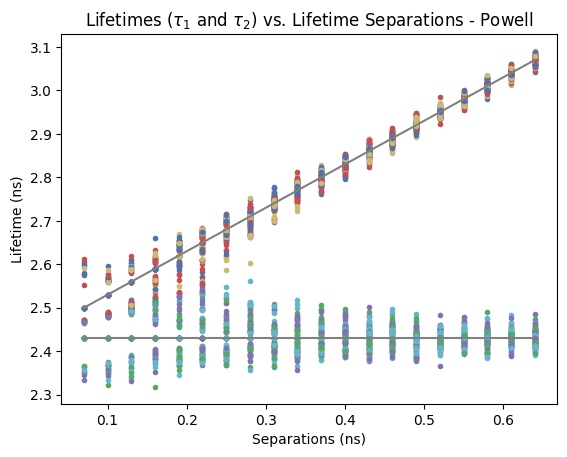

In [151]:
# Calculate separation
separations = [lifetime[0] - lifetime[1] for lifetime in lifetimes]

# Plot the fitted lifetimes against separation
plt.figure()

# Plot fitted values
for i in range(100):
    plt.errorbar(separations, tau1_array[:,i], fmt='.', linestyle='none', label='Fitted $\\tau_1$')
    plt.errorbar(separations, tau2_array[:,i], fmt='.', linestyle='none', label='Fitted $\\tau_2$')

# Plot real values
plt.errorbar(separations,tau1s, color='grey', linestyle='-', label='Real $\\tau_1$')
plt.errorbar(separations,np.linspace(2.43,2.43,20), color='grey', linestyle='-', label='Real $\\tau_2$')

plt.xlabel('Separations (ns)')  # X-axis label
plt.ylabel('Lifetime (ns)')  # Y-axis label
plt.title('Lifetimes ($\\tau_1$ and $\\tau_2$) vs. Lifetime Separations - Powell')  # Chart title
#plt.legend()

plt.show()

In [134]:
# Analyse for decreasing separation
run_time=500*60

guesses = [[0.503,tau1s[i], 2.43] for i in range(len(tau1s))] # Generate array for initial guesses

A1_array = []
tau1_array = []
tau2_array = []

for i in range(20): # Loop through the 20 pairs of lifetimes
    A1 = []
    tau1 = []
    tau2 = []

    for j in range(100): # Loop through 100 simulations
        result,params,chi2,report=exp_fit(exp2,t_array[i,j,:], y_array[i,j,:],guesses[i],run_time,method = 'COBYLA')

        A1.append(params['A1'].value)
        tau1.append(params['tau1'].value)
        tau2.append(params['tau2'].value)
    
    A1_array.append(np.array(A1))
    tau1_array.append(np.array(tau1))
    tau2_array.append(np.array(tau2))

A1_array=np.array(A1_array)
tau1_array=np.array(tau1_array)
tau2_array=np.array(tau2_array)


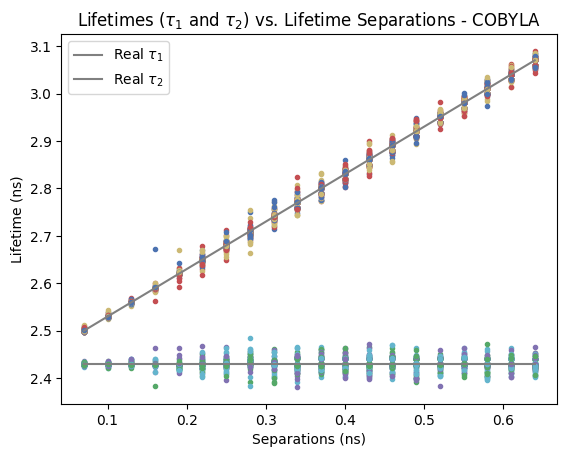

In [146]:
# Calculate separation
separations = [lifetime[0] - lifetime[1] for lifetime in lifetimes]

# Plot the fitted lifetimes against separation
plt.figure()

# Plot fitted values
for i in range(100):
    plt.errorbar(separations, tau1_array[:,i], fmt='.', linestyle='none')
    plt.errorbar(separations, tau2_array[:,i], fmt='.', linestyle='none')

# Plot real values
plt.errorbar(separations,tau1s, color='grey', linestyle='-', label='Real $\\tau_1$')
plt.errorbar(separations,np.linspace(2.43,2.43,20), color='grey', linestyle='-', label='Real $\\tau_2$')

plt.xlabel('Separations (ns)')  # X-axis label
plt.ylabel('Lifetime (ns)')  # Y-axis label
plt.title('Lifetimes ($\\tau_1$ and $\\tau_2$) vs. Lifetime Separations - COBYLA')  # Chart title
plt.legend()

plt.show()

### Also Changing Run Time

In [162]:
# Generate TCSPC data

#runtimes = np.arange(20*60,10*60*60,500)    # 20 minutes to 10 hours
runtimes = np.logspace(4,9,100)/2490

t_data = []
y_data = []

for runtime in runtimes:

    t_array_t = []
    y_array_t = []

    for lifetime in lifetimes:

        t = []
        y = []

        # Run 100 simulations for each pair of lifetimes
        for i in range(100):
            t_i,y_i = TCSPCsim([0.503,0.497],lifetime, 500*60)
            t.append(t_i)
            y.append(y_i)
        
        t_array_t.append(np.array(t))
        y_array_t.append(np.array(y))
    
    t_data.append(np.array(t_array_t))
    y_data.append(np.array(y_array_t))

t_data=np.array(t_data)
y_data=np.array(y_data)

In [163]:
t_data.shape

(100, 20, 100, 380)

In [171]:
guesses = [[0.503,tau1s[i], 2.43] for i in range(len(tau1s))] # Generate array for initial guesses

A1_results = []
tau1_results = []
tau2_results = []

# Loop through each run time
for runtime in runtimes:
    A1_array_t = []
    tau1_array_t = []
    tau2_array_t = []

    # Loop through the 20 pairs of lifetimes
    for i in range(20):
        A1 = []
        tau1 = []
        tau2 = []

        # Loop through 10 simulations
        for j in range(10):
            # Assume exp_fit is your function to fit the model, and it returns the specified values
            result, params, chi2, report = exp_fit(exp2, t_array[i,j,:], y_array[i,j,:], guesses[i], runtime, method='powell')

            A1.append(params['A1'].value)
            tau1.append(params['tau1'].value)
            tau2.append(params['tau2'].value)
        
        # Average the 10 results
        mean_tau1 = np.mean(tau1)
        mean_tau2 = np.mean(tau2)

        A1_array_t.append(np.array(A1))
        tau1_array_t.append(np.array(mean_tau1))
        tau2_array_t.append(np.array(mean_tau2))

    # After completing all simulations for the current run_time, store the arrays in the results lists
    A1_results.append(np.array(A1_array_t))
    tau1_results.append(np.array(tau1_array_t))
    tau2_results.append(np.array(tau2_array_t))

A1_results = np.array(A1_results)
tau1_results = np.array(tau1_results)
tau2_results = np.array(tau2_results)

In [174]:
tau2_results.shape

(100, 20)

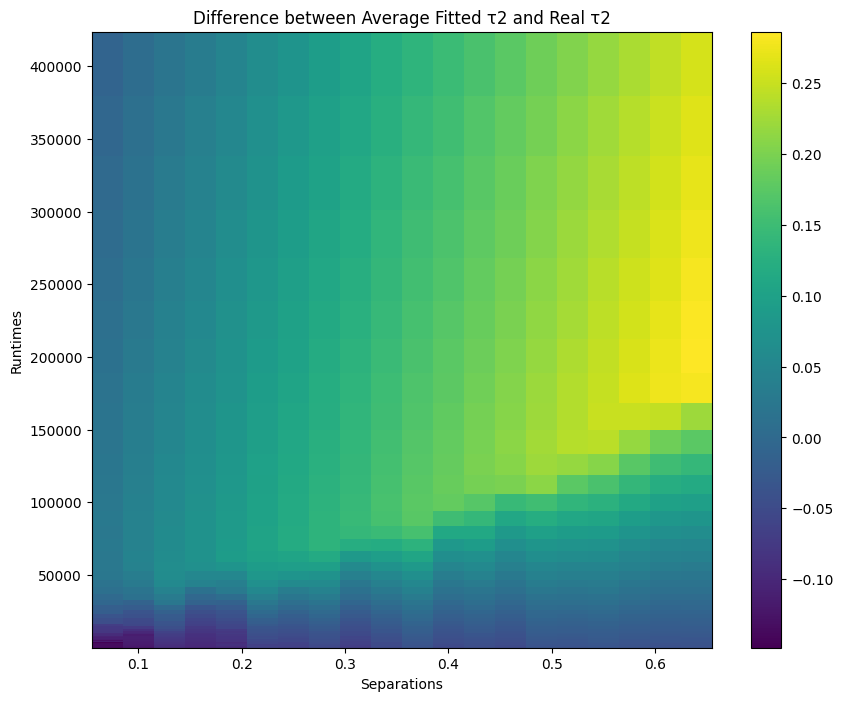

In [179]:
# Create a meshgrid for plotting
X, Y = np.meshgrid(separations[::-1], runtimes)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, tau2_results[:, ::-1] -2.43, cmap='viridis')
fig.colorbar(c, ax=ax)

ax.set_title('Difference between Average Fitted τ2 and Real τ2')
ax.set_xlabel('Separations')
ax.set_ylabel('Runtimes')

plt.show()